# Business Intelligence exam project march 2024
Group members: Rasmus, Deniz, Victor & Marcus

# Imports

In [301]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing as prep
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sklearn.metrics as sm
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


# Load and clean the data

### We engineer & wrangle

In [302]:
# Load the data. The data is from the Our World in Data's github (https://github.com/owid/covid-19-data/tree/master/public/data). downloaded on 10/03/2024
df = pd.read_csv("./Data/owid-covid-data.csv")

In [303]:
#Check that the data is loaded correctly
df.sample(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
149639,HUN,Europe,Hungary,2021-06-17,806790.0,0.0,111.714,29905.0,0.0,7.143,...,34.8,NaN,7.020,76.88,0.854,9967304.0,NaN,NaN,NaN,NaN
60668,CYM,North America,Cayman Islands,2020-12-18,298.0,0.0,1.429,2.0,0.0,0.000,...,NaN,NaN,NaN,83.92,NaN,68722.0,NaN,NaN,NaN,NaN
189344,LIE,Europe,Liechtenstein,2022-11-08,20729.0,0.0,12.143,86.0,0.0,0.000,...,NaN,NaN,2.397,82.49,0.919,39355.0,NaN,NaN,NaN,NaN
50280,BGR,Europe,Bulgaria,2021-06-26,421005.0,0.0,101.571,17989.0,0.0,13.000,...,44.4,NaN,7.454,75.05,0.816,6781955.0,NaN,NaN,NaN,NaN
319163,SSD,Africa,South Sudan,2020-02-29,NaN,0.0,0.000,NaN,0.0,0.000,...,NaN,NaN,NaN,57.85,0.433,10913172.0,NaN,NaN,NaN,NaN


In [304]:
#Print the columns to see what we have, and later decide what to use
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

### For our three hypothesis', we will use the following columns:

In [305]:
columns_to_keep_hypo1 = ['iso_code', 'location', 'total_cases', 'gdp_per_capita','date']
columns_to_keep_hypo2 = ['iso_code', 'location', 'total_cases', 'date', 'total_vaccinations_per_hundred', 'population_density']
columns_to_keep_hypo3 = ['iso_code', 'location', 'total_cases', 'human_development_index','date']

### Creating a new dataframe with the columns we've chosen

In [306]:
# new df
data_hypo1 = df[columns_to_keep_hypo1]
data_hypo2 = df[columns_to_keep_hypo2]
data_hypo3 = df[columns_to_keep_hypo3]

Check the data to see if it looks good

In [307]:
#print a sample
print(data_hypo1.sample(5))
print(data_hypo2.sample(5))
print(data_hypo3.sample(5))

       iso_code                         location  total_cases  gdp_per_capita  \
8997        AND                          Andorra      48015.0             NaN   
143662      HTI                            Haiti      20345.0        1653.173   
157848      IRQ                             Iraq    2465545.0       15663.986   
112932      FJI                             Fiji      69047.0        8702.975   
41880       BES  Bonaire Sint Eustatius and Saba      11812.0             NaN   

              date  
8997    2024-01-11  
143662  2021-08-07  
157848  2023-04-07  
112932  2024-02-02  
41880   2023-03-24  
       iso_code       location  total_cases        date  \
322959      LKA      Sri Lanka     662864.0  2022-04-23   
322704      LKA      Sri Lanka     329994.0  2021-08-11   
103224      SWZ       Eswatini      71089.0  2022-05-09   
188403      LIE  Liechtenstein         78.0  2020-04-11   
377386      YEM          Yemen      11945.0  2023-12-19   

        total_vaccinations_per_h

Get the percentage of missing values in data_hypo1

In [308]:
#Get percentage of missing values
missing_values = (data_hypo1.isnull().sum()/data_hypo1.shape[0])*100
missing_values

iso_code           0.000000
location           0.000000
total_cases       10.239973
gdp_per_capita    22.533775
date               0.000000
dtype: float64

Remove the rows with missing values in the total_cases column, because we can't get that data from anywhere else and then check the missing values again. 

In [309]:
# Remove rows
data_hypo1 = data_hypo1.dropna(subset=['total_cases'])
data_hypo2 = data_hypo2.dropna(subset=['total_cases'])
data_hypo3 = data_hypo3.dropna(subset=['total_cases'])

missing_values_hypo1 = (data_hypo1.isnull().sum()/data_hypo1.shape[0])*100
missing_values

iso_code           0.000000
location           0.000000
total_cases       10.239973
gdp_per_capita    22.533775
date               0.000000
dtype: float64

Turn the date column into a datetime object, as that's more useful for us

In [310]:
# Date column -> datetime
data_hypo1['date'] = pd.to_datetime(data_hypo1['date'])
data_hypo2['date'] = pd.to_datetime(data_hypo2['date'])
data_hypo3['date'] = pd.to_datetime(data_hypo3['date'])

#Get a list of the iso codes, to see what countries we have data for

In [311]:
# list of the iso codes
iso_codes_hypo1 = data_hypo1['iso_code'].unique()
iso_codes_hypo1

array(['AFG', 'OWID_AFR', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATG',
       'ARG', 'ARM', 'ABW', 'OWID_ASI', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR',
       'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL',
       'BES', 'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI',
       'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN',
       'COL', 'COM', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW',
       'CYP', 'CZE', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY',
       'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'OWID_EUR', 'OWID_EUN',
       'FRO', 'FLK', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM',
       'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'OWID_HIC', 'HND', 'HUN',
       'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA',
       'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'OWID_KOS', 'KWT',
       'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU

Get a list of owid special codes (which are not countries!)

In [312]:
# owid special codes
iso_codes_owid = data_hypo1[data_hypo1['iso_code'].str.contains('OWID')]['iso_code'].unique()
iso_codes_owid

array(['OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_KOS', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_OCE',
       'OWID_SAM', 'OWID_UMC', 'OWID_WRL'], dtype=object)

Remove the owid rows from the data, because we are only interested in actual countries

In [313]:
#Removing rows
data_hypo1 = data_hypo1[~data_hypo1['iso_code'].str.contains('OWID')]
data_hypo2 = data_hypo2[~data_hypo2['iso_code'].str.contains('OWID')]
data_hypo3 = data_hypo3[~data_hypo3['iso_code'].str.contains('OWID')]

Check the data to make sure all the owid rows are removed

In [314]:
# Check to see if it's done correct
iso_codes_owid = data_hypo1[data_hypo1['iso_code'].str.contains('OWID')]['iso_code'].unique()
iso_codes_owid

array([], dtype=object)

### We then find any countries that doesnt have any data in the population_density column.

Note: We use the iso code, because it is unique for each country, and other data might have different names for the same country or capital letters for a country 

In [315]:
missing_population_density = data_hypo2[data_hypo2['population_density'].isnull()]['iso_code'].unique()
missing_population_density

array(['AIA', 'BES', 'COK', 'FLK', 'GUF', 'GLP', 'GGY', 'JEY', 'MTQ',
       'MYT', 'MSR', 'NIU', 'PCN', 'REU', 'BLM', 'SHN', 'SPM', 'SSD',
       'SYR', 'TKL', 'VAT', 'WLF'], dtype=object)

We then load another dataset so we can fill some of the missing data in the population density column

In [316]:
#load dataset
pop_density = pd.read_csv("./Data/population-density.csv")

We then find the first year present in the covid dataset

In [317]:
first_year = data_hypo2['date'].min().year
first_year

2020

And then the last year in the covid dataset

In [318]:
last_year = data_hypo2['date'].max().year
last_year

2024

.. because we can then remove rows that are not within the range of the first and last year of the covid dataset, because we only need data from inside the covid-period. 

In [319]:

#discard unusuable years
pop_density = pop_density[pop_density['Year'] >= first_year]
pop_density = pop_density[pop_density['Year'] <= last_year]

Check the data to see its size

In [320]:
pop_density.shape

(1220, 4)

And if it looks good :)

In [321]:
pop_density.sample(5)

,Entity,Code,Year,Population density
25933,Germany,DEU,2022,238.615420
75117,Western Sahara,ESH,2023,2.207767
10442,Bulgaria,BGR,2020,64.288700
2684,Antigua and Barbuda,ATG,2023,214.350000
22831,European Union (27),NaN,2022,111.928330


Get the percentage of missing values in the pop_density

In [322]:
(pop_density.isnull().sum()/pop_density.shape[0])*100

Entity                0.000000
Code                  4.508197
Year                  0.000000
Population density    0.000000
dtype: float64

Check which rows has missing values in the Code column

In [323]:
pop_density[pop_density['Code'].isnull()]

,Entity,Code,Year,Population density
595,Africa,NaN,2020,45.474545
596,Africa,NaN,2021,46.577396
597,Africa,NaN,2022,47.682274
598,Africa,NaN,2023,48.810062
599,Africa,NaN,2024,49.963478
3884,Asia,NaN,2020,149.983980
3885,Asia,NaN,2021,150.956790
3886,Asia,NaN,2022,151.859040
3887,Asia,NaN,2023,152.838000
3888,Asia,NaN,2024,153.866350


We then remove rows with missing values in the Code column, as they are not useful for our analysis, as they are not associated with any country, but rather a region, continent or group of people


In [324]:
pop_density = pop_density.dropna(subset=['Code'])

We then re-check the percentage of missing values, to make sure the rows are correctly removed

In [325]:
(pop_density.isnull().sum()/pop_density.shape[0])*100

Entity                0.0
Code                  0.0
Year                  0.0
Population density    0.0
dtype: float64

Get the amount of countries in the population density dataset

In [326]:
len(pop_density['Entity'].unique())

233

Rename the population density column to make it easier to work with, when we merge the datasets

In [327]:

pop_density.rename(columns={'Entity':'location', 'Code':'iso_code','Year':'year', 'Population density': 'population_density'}, inplace=True)

Check the columns to see if the renaming was successful

In [328]:
# Check if done correct
pop_density.sample(5)

,location,iso_code,year,population_density
75452,World,OWID_WRL,2020,60.170630
8443,Bolivia,BOL,2022,11.284144
43403,Mayotte,MYT,2023,898.427800
7600,Benin,BEN,2022,118.418450
59540,Saudi Arabia,SAU,2020,16.745256


Find out if the countries in the covid dataset, with missing population_density, are in the population density dataset

In [329]:
# Discover if it exists
doesnt_exists = []
for code in missing_population_density:
    if not code in pop_density['iso_code'].unique():
        doesnt_exists.append(code)

print(len(doesnt_exists), len(missing_population_density))
print(doesnt_exists)
# this means that there is 5 countries in the covid dataset, with missing population_density, that are not in the population density dataset

5 22
['GGY', 'JEY', 'PCN', 'BLM', 'VAT']


Remove the countries that are not in the population density dataset from the covid dataset

In [330]:
#remove excess countries that are not there
data_hypo2 = data_hypo2[~data_hypo2['iso_code'].isin(doesnt_exists)]

In [331]:
data_hypo2.columns

Index(['iso_code', 'location', 'total_cases', 'date',
       'total_vaccinations_per_hundred', 'population_density'],
      dtype='object')

### Next we will fill in the missing population density data, by using the population density dataset and a new dataframe as an intermediary dataframe

### This is done by finding the population density data for the countries with missing population density, and then putting this data into a new dataframe

In [332]:
rows_with_missing_pop_density = data_hypo2[data_hypo2['population_density'].isnull()]
df_with_pop_filled = pd.DataFrame(columns=data_hypo2.columns)
for row in rows_with_missing_pop_density.iterrows():
    index = row[0]
    row = row[1]
    year = row['date'].year
    location = row['location']
    iso_code = row['iso_code']
    year_condition = pop_density['year'] == year
    iso_code_condition = pop_density['iso_code'] == iso_code
    combined_condition = year_condition & iso_code_condition
    pop_density_row = pop_density[combined_condition]
    #print(row)
    df_with_pop_filled.loc[index] = [iso_code, location, row['total_cases'], pop_density_row['population_density'].values[0], row['date'], row['total_vaccinations_per_hundred']]


Put the data from the intermediary dataframe into the original covid dataframe at the correct index

In [333]:
# put the data from intermediary df to original df
data_hypo2['population_density'] = data_hypo2['population_density'].fillna(df_with_pop_filled['population_density'])

Drop the rows with missing values in the gdp_per_capita column, because we can't get that data from anywhere else that is up to date

In [334]:
#dropping rows with missing values in gdp_per_capital column
data_hypo1 = data_hypo1.dropna(subset=['gdp_per_capita'])

In [335]:
#dropping rows with missing values in population_density
data_hypo2 = data_hypo2.dropna(subset=['population_density'])

In [336]:
(data_hypo2.isnull().sum()/data_hypo2.shape[0])*100

iso_code                           0.000000
location                           0.000000
total_cases                        0.000000
date                               0.000000
total_vaccinations_per_hundred    78.660854
population_density                 0.000000
dtype: float64

Load another dataset to so we can fill some of the missing data in the total_vaccinations_per_hundred column

In [337]:
#load another dataset to fill data
#vacc_per_hundred_dataset = pd.read_csv("./Data/covid-vaccination-doses-per-capita.csv")

In [338]:
#vacc_per_hundred_dataset.columns

In [339]:
#vacc_per_hundred_dataset.rename(columns={'Entity':'location', 'Code':'iso_code','Day':'date'}, inplace=True)

In [340]:
##vacc_per_hundred_dataset.shape

In [341]:
#rows_with_missing_vacc_per_hundred = data_hypo2[data_hypo2['total_vaccinations_per_hundred'].isnull()]
#print(f"covid data is missing {len(rows_with_missing_vacc_per_hundred)} rows")

In [342]:
# get the percentage of missing values
missing_values = (data_hypo2.isnull().sum()/data_hypo2.shape[0])*100
missing_values

iso_code                           0.000000
location                           0.000000
total_cases                        0.000000
date                               0.000000
total_vaccinations_per_hundred    78.660854
population_density                 0.000000
dtype: float64

In [343]:
data_hypo2['date'].sort_values()

123491   2020-01-05
66344    2020-01-05
123492   2020-01-06
66345    2020-01-06
123493   2020-01-07
            ...    
81403    2024-02-18
337041   2024-02-18
34681    2024-02-18
234359   2024-02-18
380459   2024-02-18
Name: date, Length: 295457, dtype: datetime64[ns]

In [344]:
#vacc_per_hundred_dataset['date'].sort_values()

In [345]:
#vacc_per_hundred_dataset['date'] = pd.to_datetime(vacc_per_hundred_dataset['date'])

In [346]:
def vacc_merge_datasets(dataset1, dataset2):
    # Convert dates to datetime objects
    dataset1['date'] = pd.to_datetime(dataset1['date'])
    dataset2['date'] = pd.to_datetime(dataset2['date'])

    # Merge datasets based on 'iso_code' and 'date'
    merged = pd.merge(dataset1, dataset2, on=['iso_code', 'date'], how='left', suffixes=('_1', '_2'))

    # Replace missing values in 'total_vaccinations_per_hundred_1' with values from 'total_vaccinations_per_hundred_2'
    merged['total_vaccinations_per_hundred'] = merged['total_vaccinations_per_hundred_1'].fillna(merged['total_vaccinations_per_hundred_2'])

    # Drop unnecessary columns
    merged.drop(['total_vaccinations_per_hundred_1', 'total_vaccinations_per_hundred_2'], axis=1, inplace=True)

    # Fill missing values in 'total_vaccinations_per_hundred' with most recent values from dataset2
    merged['total_vaccinations_per_hundred'].fillna(method='ffill', inplace=True)

    return merged

In [347]:
# test_dataset = fill_missing_vaccination_data(data_hypo2, vacc_per_hundred_dataset)
#intermediary_dataset = vacc_merge_datasets(data_hypo2, vacc_per_hundred_dataset)


In [348]:
#intermediary_dataset.sample(5)

Put the data from the intermediary dataframe into the original covid dataframe at the correct index

In [349]:
#data_hypo2['total_vaccinations_per_hundred'] = data_hypo2['total_vaccinations_per_hundred'].fillna(intermediary_dataset['total_vaccinations_per_hundred'])

Remove the rows with missing values in the total_vaccinations_per_hundred column, because we can't get that data from anywhere else and check the missing values again

In [350]:

data_hypo2 = data_hypo2.dropna(subset=['total_vaccinations_per_hundred'])

In [351]:
data_hypo2.isnull().sum()/data_hypo2.shape[0]*100

iso_code                          0.0
location                          0.0
total_cases                       0.0
date                              0.0
total_vaccinations_per_hundred    0.0
population_density                0.0
dtype: float64

In [352]:
hdi_dataset = pd.read_csv("./Data/human-development-index.csv")

In [353]:
first_year = 2020
hdi_dataset = hdi_dataset[hdi_dataset['Year'] >= first_year]
# pop_density = pop_density[pop_density['Year'] >= first_year]
hdi_dataset.reset_index(drop=True, inplace=True)


In [354]:
# Create a list of years to add
additional_years = [2023, 2024]
# Repeat the last row for each additional year
for year in additional_years:
    last_row = hdi_dataset[hdi_dataset['Year'] == hdi_dataset['Year'].max()].copy()
    last_row['Year'] = year
    hdi_dataset = pd.concat([hdi_dataset, last_row], ignore_index=True)

In [355]:
hdi_dataset.rename(columns={'Code': 'iso_code', 'Entity':'location', 'Year':'year', 'Human Development Index':'human_development_index'}, inplace=True)

In [356]:
data_hypo3['human_development_index'].isnull().sum()/data_hypo3.shape[0]*100

17.567424971292013

In [357]:
# Merge datasets based on the 'Code' and 'iso_code' columns
merged_dataset = pd.merge(data_hypo3, hdi_dataset, left_on='iso_code', right_on='iso_code', how='left')
# Fill missing HDI values in dataset 2 with corresponding values from dataset 1
merged_dataset['human_development_index_x'] = merged_dataset['human_development_index_x'].fillna(merged_dataset['human_development_index_y'])

# Drop redundant columns
data_hypo3 = merged_dataset.drop(columns=['human_development_index_y']).rename(columns={'human_development_index_x':'human_development_index', 'location_x':'location'})



In [358]:
data_hypo3 = data_hypo3.dropna(subset=['human_development_index'])

In [359]:
data_hypo3['human_development_index'].isnull().sum()/data_hypo3.shape[0]*100

0.0

In [360]:
data_hypo1.to_csv("./Data/cleaned_hypo1.csv", index=False)
data_hypo2.to_csv("./Data/cleaned_hypo2.csv", index=False)
data_hypo3.to_csv("./Data/cleaned_hypo3.csv", index=False)

# Hypothesis 1 (GNP)

### "We do not believe that there is a correlation between the number of infected individuals in relation to a country's Gross National Product (GNP) per capita."

Copy the covid data to use for hypothesis 1

In [361]:
# Copy data
data_hypothesis_1 = data_hypo1[['location', 'total_cases', 'gdp_per_capita', 'date']]

Get an overview of the data

In [362]:
data_hypothesis_1[['total_cases', 'gdp_per_capita']].describe()

,total_cases,gdp_per_capita
count,2.697960e+05,269796.000000
mean,2.160130e+06,19006.496458
std,8.324078e+06,19569.781223
min,1.000000e+00,661.240000
25%,1.362000e+04,4227.630000
50%,1.208480e+05,12895.635000
75%,8.948930e+05,27717.847000
max,1.034368e+08,116935.600000


In [363]:
data_hypo1['date'] = pd.to_datetime(data_hypo1['date'])

In [364]:
years = data_hypo1['date'].dt.year.unique()
years

array([2020, 2021, 2022, 2023, 2024])

Piechart to show  the top 5 countries with the highest average total cases for each year that we have data for as a single graph.

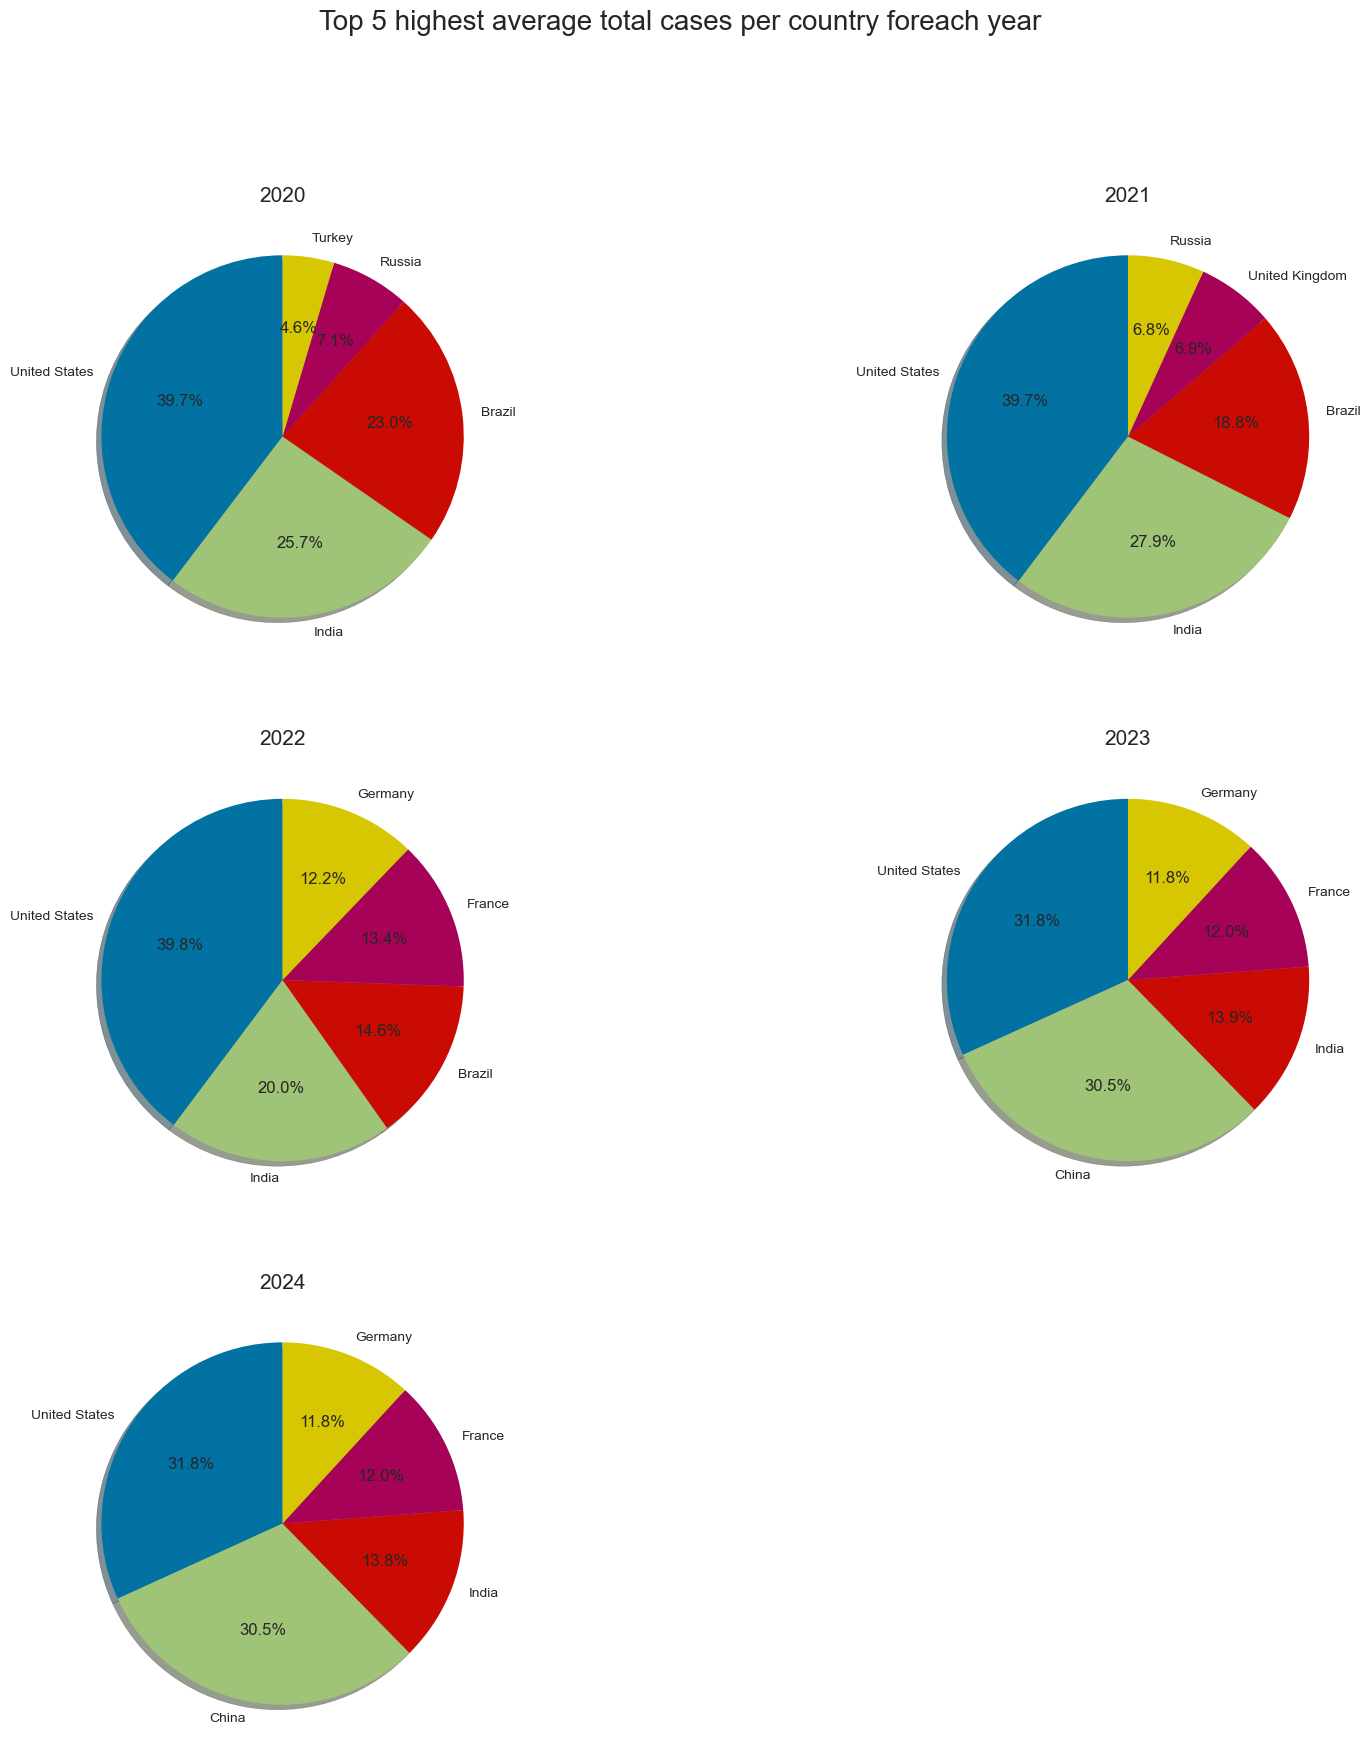

In [365]:

fig = plt.figure(figsize=(20, 20))

for i, y in enumerate(years, start=1):
    plt.subplot(3, 2, i)
     # get the avg total cases per country for the year
    avg_total_cases = data_hypo1[data_hypo1['date'].dt.year == y].groupby('location')['total_cases'].mean()
    avg_total_cases = avg_total_cases.reset_index()
    avg_total_cases = avg_total_cases.sort_values(by='total_cases', ascending=False)
    # get the top 5 countries
    top_5 = avg_total_cases.head(5)
    plt.pie(top_5['total_cases'], labels=top_5['location'], autopct='%.1f%%',
            startangle=90, shadow=True)
    plt.title(y, fontsize=15)

plt.suptitle('Top 5 highest average total cases per country foreach year', fontsize=20)
plt.show()

Get the last row for each countries latest observation

In [366]:

last_row = data_hypothesis_1.groupby('location').last().reset_index()
last_row.sample(5)

,location,total_cases,gdp_per_capita,date
99,Luxembourg,391093.0,94277.965,2024-02-18
136,Poland,6658852.0,27216.445,2024-02-18
175,Tunisia,1153361.0,10849.297,2024-02-18
57,Eswatini,75191.0,7738.975,2024-02-18
120,Netherlands,8635061.0,48472.545,2024-02-18


Check if the last row for each country has the same date, so the data fits

In [367]:

last_row['date'].max() == last_row['date'].min()

True

We then create a subset of the data to use for the graph, where it is sorted by the total_cases

In [368]:
# graph of the cumulative cases per country
data_hypothesis_1_subset = last_row.sort_values('total_cases', ascending=False)
plt.figure(figsize=(200,100))
sns.barplot(x='location', y='total_cases', data=data_hypothesis_1_subset)
plt.xticks(rotation=90)
plt.show()

In [369]:
# graph of the cumulative cases per country
data_hypothesis_1_subset = last_row.sort_values('gdp_per_capita', ascending=False)
plt.figure(figsize=(200,100))
sns.barplot(x='location', y='gdp_per_capita', data=data_hypothesis_1_subset)
plt.xticks(rotation=90)
plt.show()

Scatterplot to show gdp_per_capita as x and total_cases for each country as y

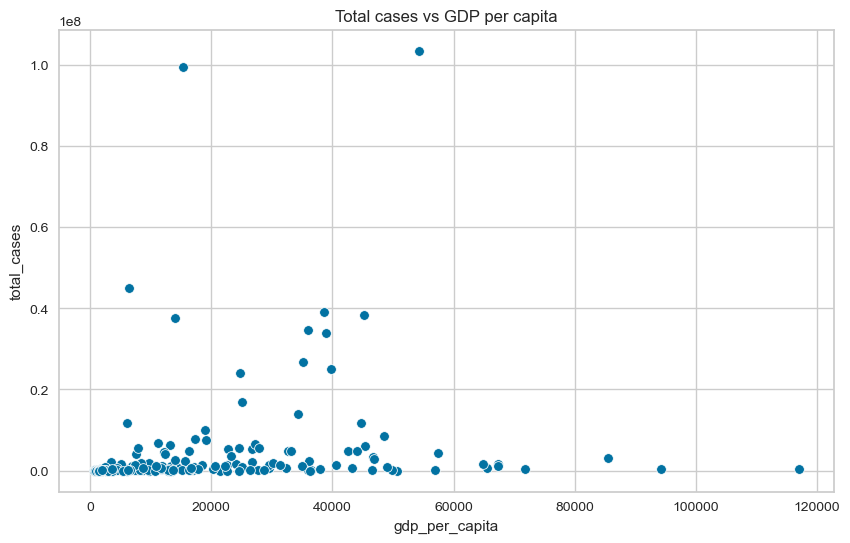

In [370]:
# scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp_per_capita', y='total_cases', data=last_row)
plt.title('Total cases vs GDP per capita')
plt.show()

Here we can see the each country's BNP per capita and the number of infected people in the country. We can also see that there is 3 outliers in the data. These are (China), (USA) and (Italy). We will remove these from the data to get a better overview of the data.

In [371]:
from sklearn.preprocessing import PolynomialFeatures
import math

In [372]:
class mul_lin_reg_model:
    r2_score_ = 0
    MAE = 0
    MSE = 0
    RMSE = 0
    eV = 0

    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y,  random_state=123, test_size=0.15)
        self.reg = LinearRegression()
        self.reg.fit(self.X_train, self.y_train)
        self.X = X
        self.y = y
    def predict(self, input):
        return self.reg.predict(input)
    
    def do_scoring_(self, y_test, y_predicted):
        self.MAE = metrics.mean_absolute_error(y_test, y_predicted) 
        self.MSE = metrics.mean_squared_error(y_test, y_predicted)
        self.RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_predicted))
        self.eV = round(sm.explained_variance_score(y_test, y_predicted), 2)
        self.r2_score_ = r2_score(y_test, y_predicted)

In [373]:
def train_mul_lin_reg(dataset):
    country_subset = dataset.groupby('location').last().reset_index()
    x_col = 'gdp_per_capita'
    y_col = 'total_cases'
    X = country_subset[x_col].values.reshape(-1, 1)
    y = country_subset[y_col].values.reshape(-1, 1)
    return mul_lin_reg_model(X,y)

In [374]:
print(data_hypo1.groupby('location').last().reset_index().sort_values('total_cases').head(5))
print(data_hypo1.groupby('location').last().reset_index().sort_values('total_cases').tail(5))

                  location iso_code  total_cases  gdp_per_capita       date
177                 Tuvalu      TUV       2943.0        3575.104 2024-02-18
89                Kiribati      KIR       5085.0        1981.132 2024-02-18
118                  Nauru      NRU       5393.0       12895.635 2024-02-18
129                  Palau      PLW       6265.0       13240.405 2024-02-18
143  Saint Kitts and Nevis      KNA       6607.0       24654.385 2024-02-18
          location iso_code  total_cases  gdp_per_capita       date
65         Germany      DEU   38437756.0       45229.245 2024-02-18
61          France      FRA   38997490.0       38605.671 2024-02-18
77           India      IND   45028053.0        6426.674 2024-02-18
37           China      CHN   99331724.0       15308.712 2024-02-18
182  United States      USA  103436829.0       54225.446 2024-02-18


In [375]:
lin_reg_model = train_mul_lin_reg(data_hypo1)

model scoring: mae: 515809645.1604351, mse: 2.000272673181712e+18, rmse: 1414309963.615371, r2_score: -17575.336590090286, eV: -15237.48
[[124.44423385]] [1630638.51791867]


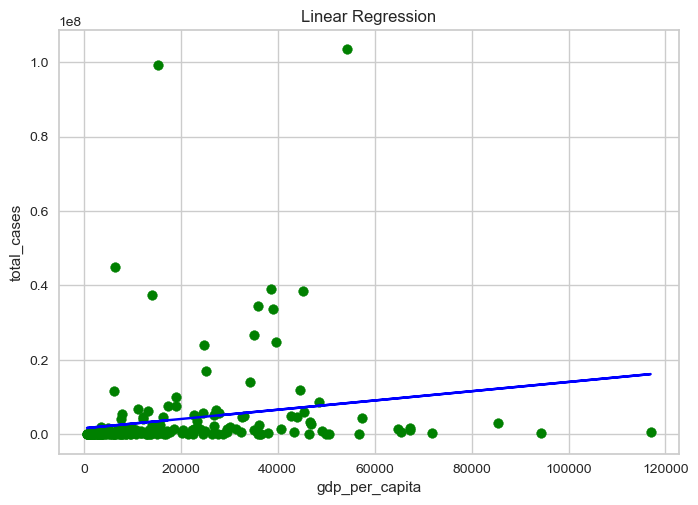

In [376]:
model = lin_reg_model
predictions = model.predict(model.y_test)
#print(predictions)
model.do_scoring_(model.y_test, predictions)
print(f"model scoring: mae: {model.MAE}, mse: {model.MSE}, rmse: {model.RMSE}, r2_score: {model.r2_score_}, eV: {model.eV}")
# Visualise the Linear Regression
a = model.reg.coef_
b = model.reg.intercept_
print(a, b)
plt.title(f'Linear Regression')
plt.scatter(model.X, model.y, color='green')
plt.plot(model.X_train, a*model.X_train+b , color='blue')
#plt.plot(model.X_test, predictions, color='orange')
plt.xlabel('gdp_per_capita')
plt.ylabel('total_cases')
plt.show()


# Hypothesis 2 (Vaccination rates)

### "We believe there is a connection between a country's population density and the number of COVID-19 cases, where higher population density correlates with more COVID-19 cases. That is to say, countries with more cases also had higher vaccination coverage."

We've chosen to show 'total_vaccinations_per_hundred' through a histogram. The histogram shows us a visual representation of the data throughout the whole world. 

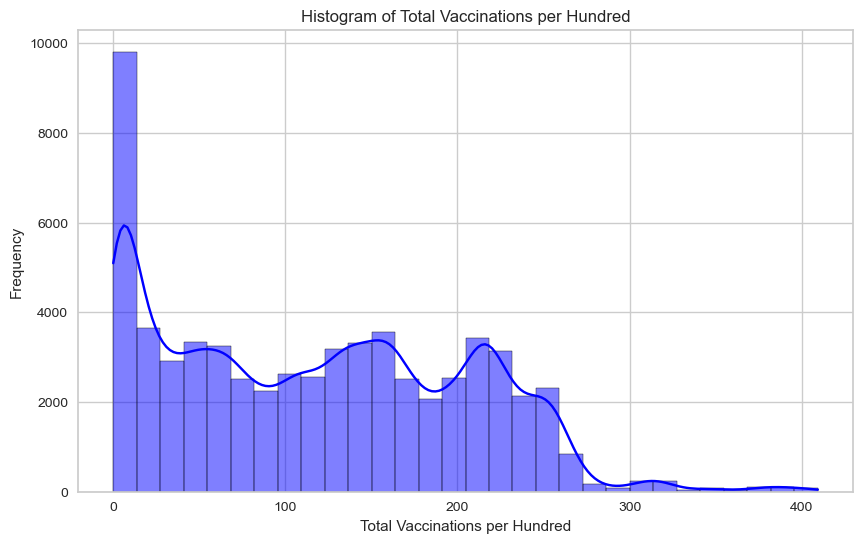

In [377]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data_hypo2['total_vaccinations_per_hundred'], kde=True, color='blue', bins=30)
plt.title('Histogram of Total Vaccinations per Hundred')
plt.xlabel('Total Vaccinations per Hundred')
plt.ylabel('Frequency')
plt.show()

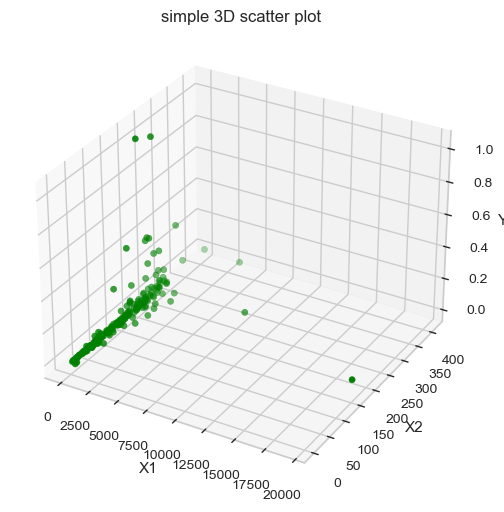

In [378]:
last_row_subset = data_hypo2.groupby('location').last().reset_index()
#Creating figure
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection='3d')
#Creating plot
ax.scatter3D( last_row_subset['population_density'], last_row_subset['total_vaccinations_per_hundred'], last_row_subset['total_cases'], color = "green")
plt.title("simple 3D scatter plot")
plt.grid()
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [379]:
fig = px.scatter_3d(last_row_subset, x="population_density", y="total_vaccinations_per_hundred", z='total_cases', color="population_density", size='total_vaccinations_per_hundred', size_max=40, opacity=0.8)
fig.show()

Moving on from our histogram of the world, we decided to dwelve into more specific countries; the nordics. 

We want to show the volume of both the vaccines and cases per hundred people. So first we prepare our data and arrange it properly in the dataset.

In [380]:
# List of Nordic countries
nordic_countries = ['Denmark', 'Norway', 'Sweden', 'Finland', 'Greenland']

# Copy the necessary columns to the hypothesis 2 dataframe
data_hypothesis_2 = data_hypo2[['location', 'total_cases', 'total_vaccinations_per_hundred', 'population_density', 'date']]

# Create empty dictionaries to store data for each Nordic country
nordic_data = {}

# Iterate over each Nordic country and extract the data
for country in nordic_countries:
    nordic_data[country] = data_hypothesis_2[data_hypothesis_2['location'] == country]

# Check the data for each Nordic country
for country, country_data in nordic_data.items():
    print(f"{country} data:")
    print(country_data.head())



Denmark data:
      location  total_cases  total_vaccinations_per_hundred  \
86290  Denmark     107116.0                            0.00   
86297  Denmark     131606.0                            0.00   
86304  Denmark     151167.0                            0.09   
86311  Denmark     167541.0                            1.56   
86318  Denmark     180240.0                            2.32   

       population_density       date  
86290              136.52 2020-12-18  
86297              136.52 2020-12-25  
86304              136.52 2021-01-01  
86311              136.52 2021-01-08  
86318              136.52 2021-01-15  
Norway data:
       location  total_cases  total_vaccinations_per_hundred  \
251859   Norway      35999.0                             0.0   
251865   Norway      38491.0                             0.0   
251866   Norway      38491.0                             0.0   
251867   Norway      38491.0                             0.0   
251868   Norway      38491.0            

In [381]:
# Copy the necessary columns to the hypothesis 2 dataframe
data_hypothesis_2 = data_hypo2[['location', 'total_cases', 'total_vaccinations_per_hundred', 'population_density', 'date']]
denmark_data = data_hypothesis_2[data_hypothesis_2['location'] == 'Denmark']
norge_data = data_hypothesis_2[data_hypothesis_2['location'] == 'Norway']
sweden_data = data_hypothesis_2[data_hypothesis_2['location'] == 'Sweden']
finland_data = data_hypothesis_2[data_hypothesis_2['location'] == 'Finland']
greenland_data = data_hypothesis_2[data_hypothesis_2['location'] == 'Greenland']
# Check the data to see if it looks good
print(data_hypothesis_2.head())

        location  total_cases  total_vaccinations_per_hundred  \
414  Afghanistan      55604.0                            0.00   
420  Afghanistan      55714.0                            0.02   
436  Afghanistan      55985.0                            0.13   
458  Afghanistan      56676.0                            0.29   
473  Afghanistan      57793.0                            0.58   

     population_density       date  
414              54.422 2021-02-22  
420              54.422 2021-02-28  
436              54.422 2021-03-16  
458              54.422 2021-04-07  
473              54.422 2021-04-22  


In [382]:
data_hypothesis_2.isnull().sum()

location                          0
total_cases                       0
total_vaccinations_per_hundred    0
population_density                0
date                              0
dtype: int64

Remove rows with missing values in the 'total_cases' column

In [383]:
data_hypothesis_2.dropna(subset=['total_cases'], inplace=True)


C:\Users\Marcus\AppData\Local\Temp\ipykernel_16968\1979015792.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [384]:
data_hypothesis_2.describe()

,total_cases,total_vaccinations_per_hundred,population_density,date
count,6.304800e+04,63048.000000,63048.000000,63048
mean,4.457535e+06,117.484288,297.593433,2022-02-11 18:19:02.900647168
min,1.000000e+00,0.000000,0.000000,2020-12-02 00:00:00
25%,1.293070e+05,38.090000,35.608000,2021-07-18 00:00:00
50%,7.282660e+05,115.020000,96.254000,2021-12-27 00:00:00
75%,3.854354e+06,188.852500,231.447000,2022-07-30 00:00:00
max,1.033436e+08,409.330000,19347.500000,2024-02-18 00:00:00
std,1.126166e+07,86.095723,950.546467,NaN


Get the last row for each countries latest observation

In [385]:
last_row = data_hypothesis_2.groupby('location').last().reset_index()
last_row.sample(5)

,location,total_cases,total_vaccinations_per_hundred,population_density,date
136,Nicaragua,15713.0,223.18,51.667,2023-08-11
53,Democratic Republic of Congo,97222.0,19.00,35.879,2023-06-04
37,Cayman Islands,31472.0,221.14,256.496,2023-06-09
173,South Africa,4072533.0,69.79,46.754,2023-09-24
104,Laos,211771.0,147.57,29.715,2022-08-11


In [386]:

last_row = data_hypothesis_2.groupby('location').last().reset_index()
last_row.sample(5)

,location,total_cases,total_vaccinations_per_hundred,population_density,date
159,Samoa,16737.0,203.73,69.413,2023-04-17
137,Niger,9515.0,28.13,16.955,2023-07-30
33,Cambodia,138956.0,285.04,90.672,2023-12-07
82,Guinea-Bissau,9614.0,43.73,66.191,2023-10-15
68,Finland,1499712.0,240.53,18.136,2024-01-09


After this is done, we're creating our first visual: a bar plot to show total vaccinations per hundred in the nordics.

Next up is a scatterplot, to explore the relationships between our variables.

First up, we show a scatterplot showing how many covid-cases happened over time.

In [387]:
# Filtrer dataene kun for nordic_countries
nordic_data = data_hypothesis_2[data_hypothesis_2['location'].isin(nordic_countries)]

# Opret et scatterplot med plotly
fig = px.scatter(nordic_data, x='date', y='total_cases', color='location', hover_name='location',
                 labels={'date': 'Date', 'total_cases': 'Total COVID-19 Cases'},
                 title='Relationship between COVID-19 Cases and the timeperiod 2020-2024 in the Nordic Countries')

# Vis plottet
fig.show()

Then we show a scatterplot showing how many vaccinations per hundred happened over time.

Test til MARCUS

In [388]:
# Filtrer dataene kun for nordic_countries
nordic_data = data_hypothesis_2[data_hypothesis_2['location'].isin(nordic_countries)]

# Opret et scatterplot med plotly
fig = px.scatter(nordic_data, x='date', y='total_vaccinations_per_hundred', color='location', hover_name='location',
                 labels={'date': 'Date', 'total_vaccinations_per_hundred': 'Vaccinations per Hundred'},
                 title='Relationship between Vaccination Coverage and the timeperiod 2020-2024 in the Nordic Countries')

# Vis plottet
fig.show()

With these two plots, we can piece things a bit more together. All countries had a pretty slow start, but increased their vaccine coverage as more cases happened. 



In [389]:
# filtrere data_hypothesis_2 for kun nordiske lande
data_hypothesis_2_subset = data_hypothesis_2[data_hypothesis_2['location'].isin(nordic_countries)]

# De nordiske lande med det højeste gennemsnitlige antal sager for vaccinationsdækning per hundred
top_5_nordic_countries = data_hypothesis_2_subset[data_hypothesis_2_subset['location'].isin(nordic_countries)].groupby('location')['total_vaccinations_per_hundred'].mean().nlargest(5).index

# subset af data, der kun indeholder de nordiske lande med det højeste gennemsnitlige antal sager for vaccinationsdækning per hundred
top_5_nordic_data = data_hypothesis_2_subset.sort_values('total_vaccinations_per_hundred', ascending=True)
# søjlediagram med plotly for de nordiske lande med farvefulde søjler baseret på total_cases
fig = px.bar(top_5_nordic_data, x='location', y='total_vaccinations_per_hundred', color='total_vaccinations_per_hundred',
             labels={'total_vaccinations_per_hundred': 'Gennemsnitlig vaccinationsdækning per hundrede', 'location': 'Land'},
             title='Top 5 nordiske lande med det højeste gennemsnitlige antal sager for vaccinationsdækning per hundrede')

# Vis plottet
fig.show()
#test til 

In this histogram, we can see how many cases happened per observation in the nordic countries.

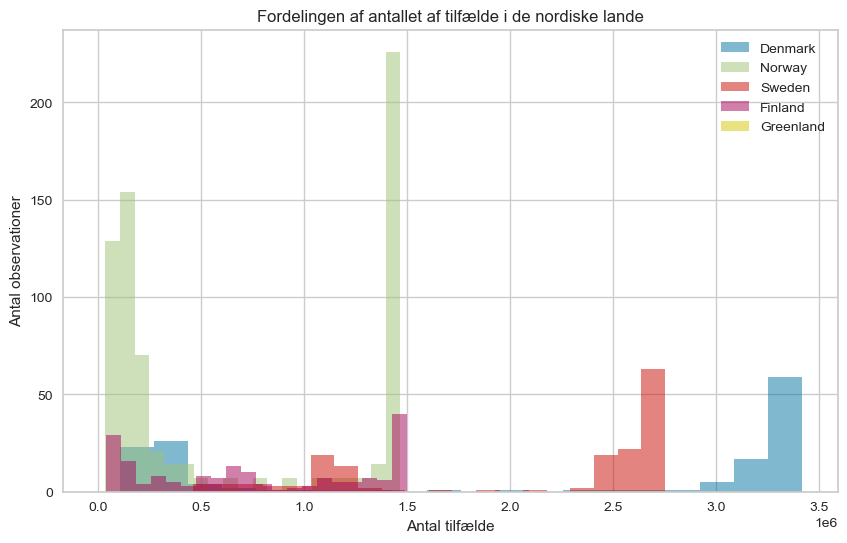

In [390]:
# histogram for total_cases i de nordiske lande
plt.figure(figsize=(10, 6))
for country in nordic_countries:
    country_data = data_hypothesis_2_subset[data_hypothesis_2_subset['location'] == country]
    plt.hist(country_data['total_cases'], bins=20, alpha=0.5, label=country)

plt.title('Fordelingen af antallet af tilfælde i de nordiske lande')
plt.xlabel('Antal tilfælde')
plt.ylabel('Antal observationer')
plt.legend()
plt.show()

In [391]:
# -liste over funktionernes navne
feature_cols = ['total_vaccinations_per_hundred', 'total_cases']

# Brug listen til at vælge en undermængde af det oprindelige datasæt kun for nordiske lande
X = data_hypo2[data_hypo2['location'].isin(nordic_countries)][feature_cols]

# Udskriv y for at forstå dens form
print(y)

# Udskriv X
print(X)

2024
        total_vaccinations_per_hundred  total_cases
86290                             0.00     107116.0
86297                             0.00     131606.0
86304                             0.09     151167.0
86311                             1.56     167541.0
86318                             2.32     180240.0
...                                ...          ...
328109                          268.09    2748782.0
328116                          268.17    2749365.0
328123                          268.23    2749793.0
328130                          268.29    2750142.0
328137                          268.33    2750430.0

[1318 rows x 2 columns]


We've then made a Heatmap to show the pairwise correlation coefficients between our variables.

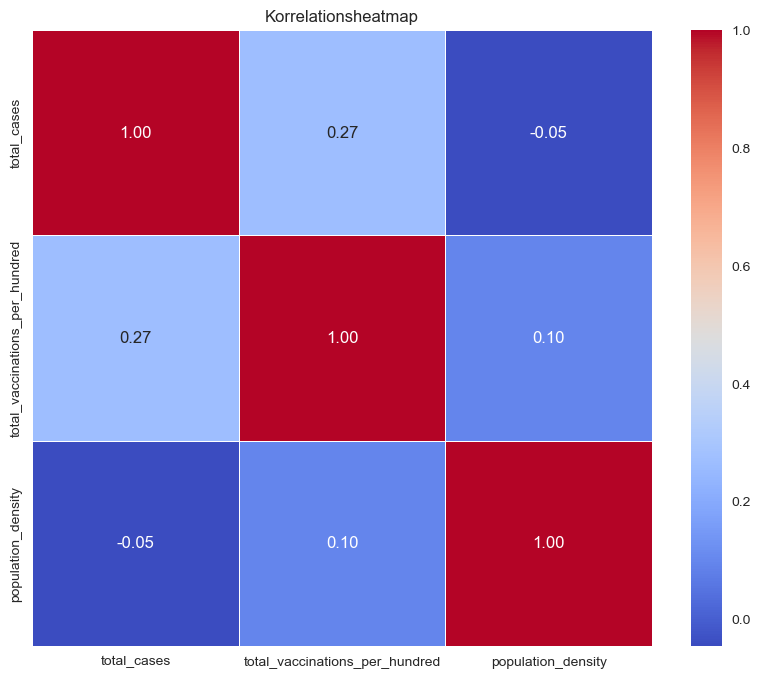

In [392]:

# Filtrér datasættet for kun numeriske kolonner
numerical_data_hypo2 = data_hypo2.select_dtypes(include='number')

# Beregn korrelationskoefficienter
correlation_matrix = numerical_data_hypo2.corr()

# Lav en heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsheatmap')
plt.show()

##  Train a Model

### To demonstrate a bit of machine learning, we've decided to train a model based on total cases and total vaccinations per hundred, to follow up from visuals from above.

### We're trying to train our model to try and predict whether or not these two features relates to an increase in covid cases.

First we prepare X and Y

In [393]:
# Opret en Series for y (total_cases) for Danmark
y = data_hypo2[data_hypo2['location'] == 'Denmark']['total_cases']

# Opret et nyt DataFrame X med de valgte funktioner (total_vaccinations_per_hundred og population_density) for Danmark
X = data_hypo2[data_hypo2['location'] == 'Denmark'][['total_vaccinations_per_hundred']]

# Opret et nyt X-dataframe kun med nordiske lande
X =  X[X.index.isin(y.index)]

print(X.head())

       total_vaccinations_per_hundred
86290                            0.00
86297                            0.00
86304                            0.09
86311                            1.56
86318                            2.32


In [394]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [395]:
#default split 75:25
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(109, 1)
(109,)
(37, 1)
(37,)


Linear regression

In [396]:
# Opret en model
linreg = LinearRegression()

# Tilpas modellen til vores træningsdata
linreg.fit(X_train, y_train)

LinearRegression()

In [397]:
print('b0 =', linreg.intercept_)
print('bi =', linreg.coef_)

b0 = -463333.20610529557
bi = [14278.71200142]


In [398]:
# Denne kode kombinerer navnene på funktionerne med deres tilsvarende koefficienter ved hjælp af zip
list(zip(feature_cols, linreg.coef_))

[('total_vaccinations_per_hundred', 14278.712001424059)]

### Testing the Model

In [399]:
y_predicted = linreg.predict(X_test)
y_predicted

array([3101632.81929025, 2679696.87964817, 2322443.50537254,
       2690548.70076925, 3166600.95889673, 2689549.19092915,
       3166600.95889673, 3166743.74601674, 1671191.45098759,
       2642001.07996441, -422924.45114127, -179900.77287703,
       2703542.32869055, -241870.38296321, 3071361.94984723,
       1353204.53471587, 3166743.74601674,  936408.9313943 ,
       3166743.74601674, 1505558.39177107, 2688264.10684902,
       2698687.56661006, 1183573.43613896, 3166600.95889673,
       1782137.04323865,  -15552.79774064, 3166886.53313676,
       3166458.17177671, 2716250.38237181, 2693690.01740956,
       3166743.74601674, 1985608.68925894, 1636208.6065841 ,
       3163745.21649644,  812469.71122194, 1616075.62266209,
       3158033.73169587])

### Model Evaluation Metrics

In [400]:
# Den beregnede værdi, som du får, er det gennemsnitlige absolutte fejl (Mean Absolute Error - MAE) mellem de faktiske salgsværdier (y_test) og de forudsagte salgsværdier (y_predicted).
print(metrics.mean_absolute_error(y_test, y_predicted))

608541.6743717458


In [401]:
# beregner gennemsnittet af de kvadrerede forskelle mellem de faktiske og forudsagte værdier.
print(metrics.mean_squared_error(y_test, y_predicted))

560913608778.2681


In [402]:
# RMSE tager kvadratroden af MSE for at give os en værdi, der er på samme skala som den oprindelige responsvariabel.
print(np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

748941.6591285786


In [403]:
# R-squared
r2_score(y_test, y_predicted)

0.7338965628971608

In [404]:
linreg.score(X_test, y_test)

0.7338965628971608

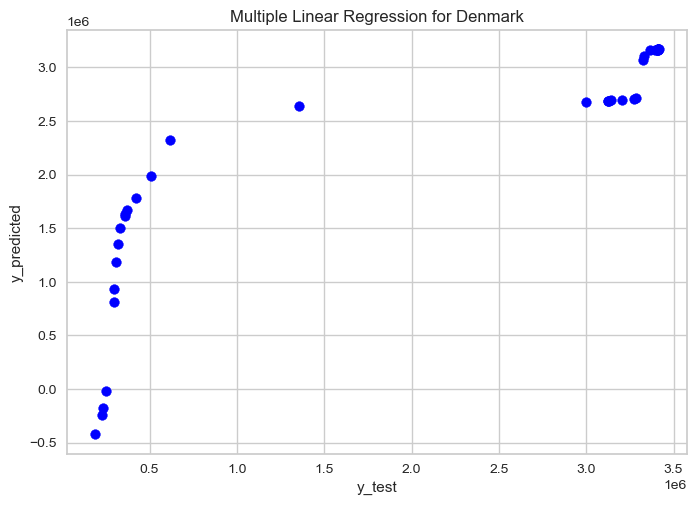

In [405]:
# Visualise the regression results
plt.title('Multiple Linear Regression for Denmark')
plt.scatter(y_test, y_predicted, color='blue')
plt.xlabel('y_test')
plt.ylabel('y_predicted')
plt.show()


Resultatet af hypotese 2-analysen viser en r2_score-værdi på 0.02203030.... Denne værdi indikerer, at den lineære model, der blev anvendt til at undersøge sammenhængen mellem befolkningstæthed, antallet af COVID-19-tilfælde og vaccinationsdækning per hundrede, ikke passer godt til dataene. En lav r2_score-værdi antyder, at andre faktorer ud over befolkningstæthed og vaccinationsdækning sandsynligvis spiller en væsentlig rolle i antallet af COVID-19-tilfælde. Derfor kan vi ikke konkludere, at der er en stærk sammenhæng mellem disse variabler baseret på denne analyse alene. Yderligere undersøgelser eller inkludering af andre faktorer kan være nødvendige for at opnå et mere præcist resultat.

# Hypotese 3 (CovidData)

### "We do not believe that development of a  country (hdi) correlates to how exposed a county is to infection"



In [406]:
#Copy necessary data
# Copy columns
print(data_hypo3.columns)
data_hypothesis_3 = data_hypo3[['human_development_index', 'total_cases', 'location', 'date']]


# Check the data to see if it looks good
print(data_hypothesis_3.head())

Index(['iso_code', 'location', 'total_cases', 'human_development_index',
       'date', 'location_y', 'year'],
      dtype='object')
   human_development_index  total_cases     location       date
0                    0.511          1.0  Afghanistan 2020-03-01
1                    0.511          1.0  Afghanistan 2020-03-01
2                    0.511          1.0  Afghanistan 2020-03-01
3                    0.511          1.0  Afghanistan 2020-03-01
4                    0.511          1.0  Afghanistan 2020-03-02


In [407]:
# get the last row for each country
last_row = data_hypothesis_3.groupby('location').last().reset_index()
last_row.sample(5)

,location,human_development_index,total_cases,date
155,Solomon Islands,0.567,25954.0,2024-02-18
46,Denmark,0.940,3434162.0,2024-02-18
134,Philippines,0.718,4140383.0,2024-02-18
8,Australia,0.944,11785451.0,2024-02-18
113,Montenegro,0.829,251280.0,2024-02-18


In [408]:
#  Reshaping the 'human_development_index' and 'total_cases' data 
#  into a format suitable for machine learning models.
#  X contains the 'human_development_index' values, reshaped to a single column.
#  y contains the 'total_cases' values, reshaped to a single column.

X = last_row['human_development_index'].values.reshape(-1, 1);
y = last_row['total_cases'].values.reshape(-1, 1);


In [409]:
# Determine k by minimizing the distortion - 
# the sum of the squared distances between each observation vector and its centroid
distortions = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k).fit(X)
    model.fit(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]) 
print("Distortion: ", distortions)

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Use

Distortion:  [0.06545049130763415, 0.04415418423261563, 0.03420709546241464, 0.02571622397890551, 0.021841374756930303, 0.018774397293720966, 0.016201829763161705, 0.014361592499765735]


c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



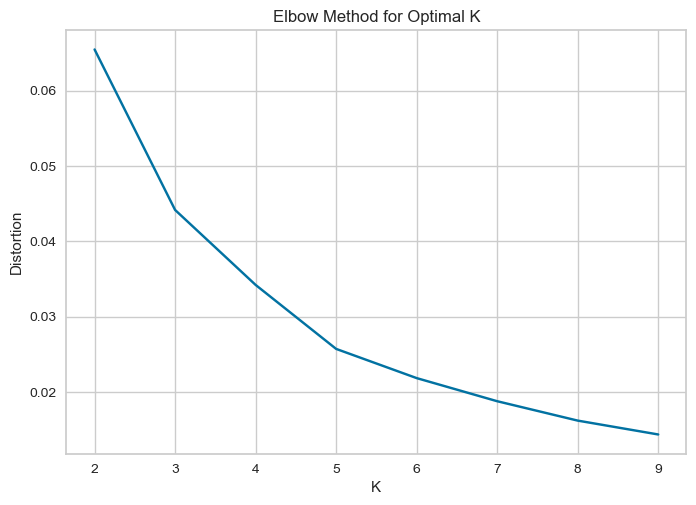

In [410]:
# Plot the distortion to discover the elbow
plt.title('Elbow Method for Optimal K')
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

From the graph, think the best K is 5

In [411]:
# Optimal number of clusters K
num_clusters = 6

In [412]:
# next we create the KMeans model and fit it to the data 
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=20)

kmeans.fit(X)

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=6, n_init=20)

In [413]:
# Calculating silhouette scores for different values of K (number of clusters)
# in KMeans clustering to determine the optimal number of clusters.
scores = []
K = range(2,10)
for k in K:
    # Create a KMeans model with k clusters and fit it to the data.
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X)
    score = metrics.silhouette_score(X, model.labels_, metric='euclidean', sample_size=len(X))
    scores.append(score)

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

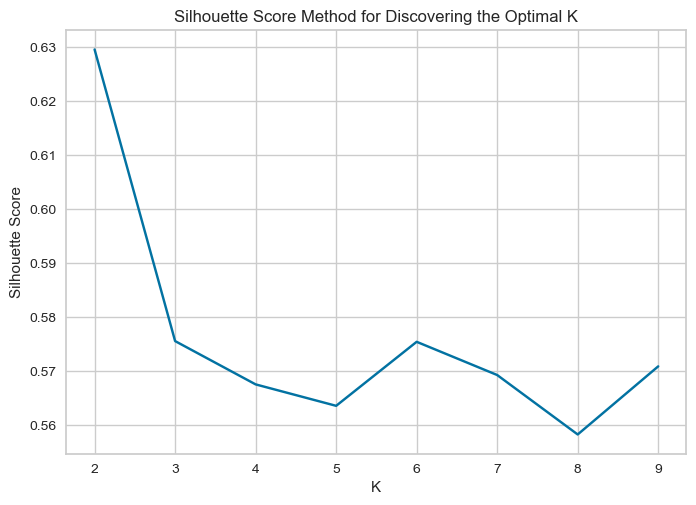

In [414]:
# Plot the elbow
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

When looking at the graph the best number of clusters is 6 when we use Silhouette method.

In [415]:
# Predict the clusters for each observation
predictions = kmeans.predict(X)
print(predictions)

[0 1 2 1 0 2 1 2 4 4 2 1 1 5 1 1 4 2 0 5 2 2 2 2 1 1 3 3 5 0 4 5 3 3 1 2 2
 0 0 1 0 1 2 4 4 3 4 0 2 2 2 2 5 5 3 4 5 3 2 4 4 2 3 1 4 5 4 2 5 3 3 5 0 5
 1 4 5 2 2 5 4 4 4 2 4 2 1 5 5 1 2 5 1 2 0 3 2 4 4 4 0 3 1 2 3 4 2 0 1 2 5
 2 2 1 5 3 0 5 5 4 4 5 3 0 2 4 1 0 1 2 1 0 2 2 2 4 1 1 1 1 0 2 2 2 2 1 5 1
 0 1 1 3 4 1 4 0 2 4 3 4 2 0 2 4 4 0 5 0 2 5 0 2 1 2 1 5 0 2 4 4 4 1 2 5 2
 2 3 0 0]


In [416]:
# Add the cluster labels to the last_row dataframe
last_row['cluster_label'] = kmeans.labels_

In [417]:
# test if the labels are added correctly to the dataset, with a singapore (chosen randomly) as an example
singapore = last_row[last_row['location'] == 'Singapore']
test_input = singapore['human_development_index'].values.reshape(-1, 1)
test_prediction = kmeans.predict(test_input)
print(f"test cluster: {test_prediction}, actual cluster: {singapore['cluster_label'].values}")

test cluster: [4], actual cluster: [4]


Cluster  0 :  (26, 5)


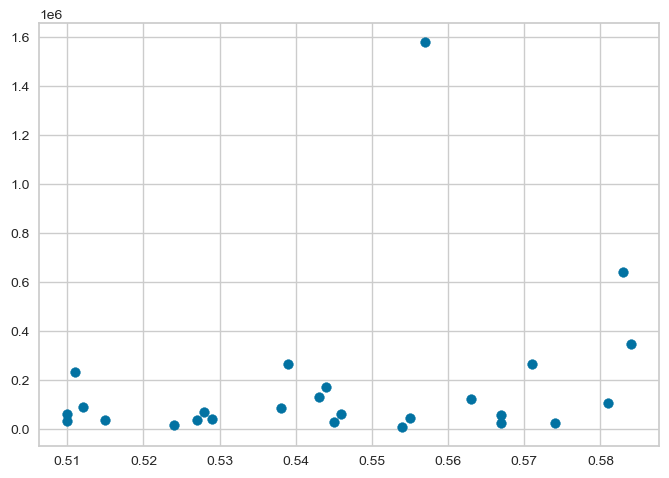

Cluster  1 :  (35, 5)


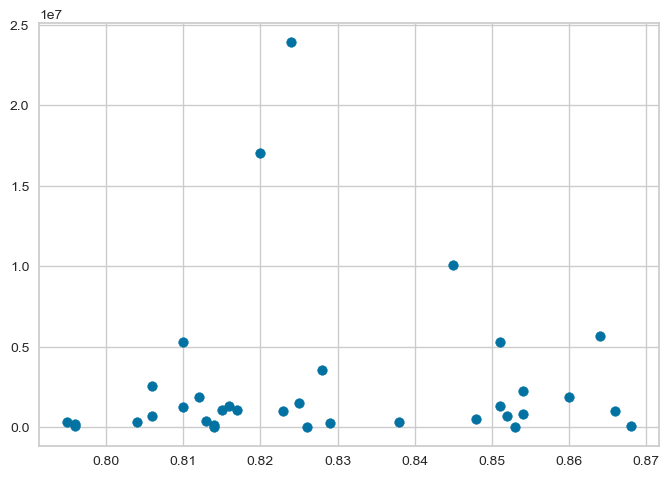

Cluster  2 :  (50, 5)


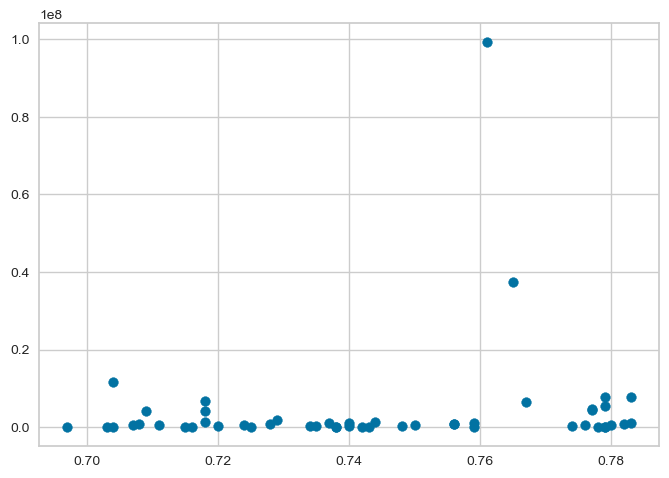

Cluster  3 :  (18, 5)


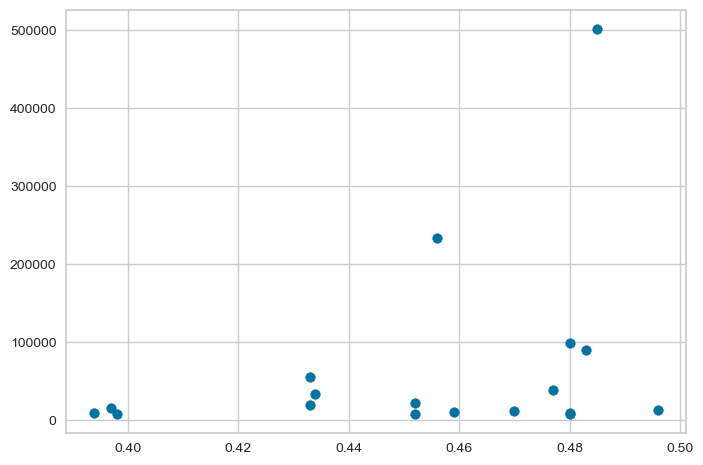

Cluster  4 :  (34, 5)


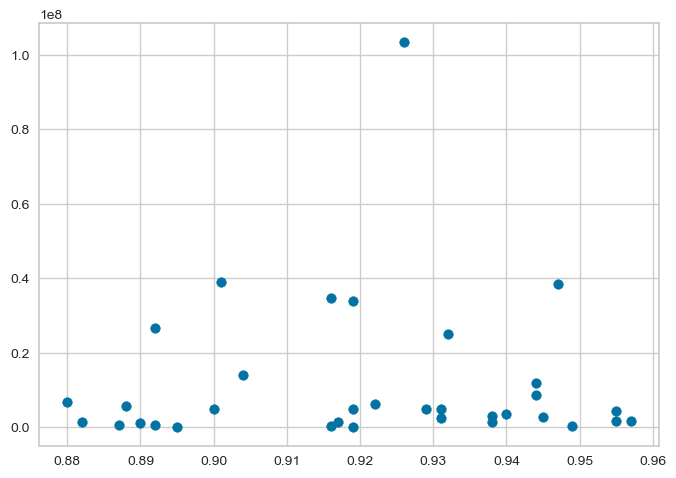

Cluster  5 :  (26, 5)


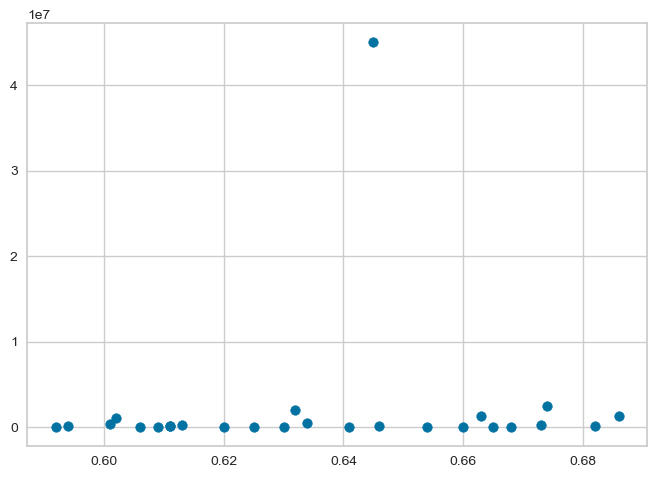

In [418]:
# Split the clusters, for demo purpose only
for i in range(num_clusters):
    # slice the cluster
    cluster = last_row[last_row['cluster_label'] == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster['human_development_index'].values.reshape(-1, 1), cluster['total_cases'].values.reshape(-1, 1))   
    plt.grid(True)
    plt.show()

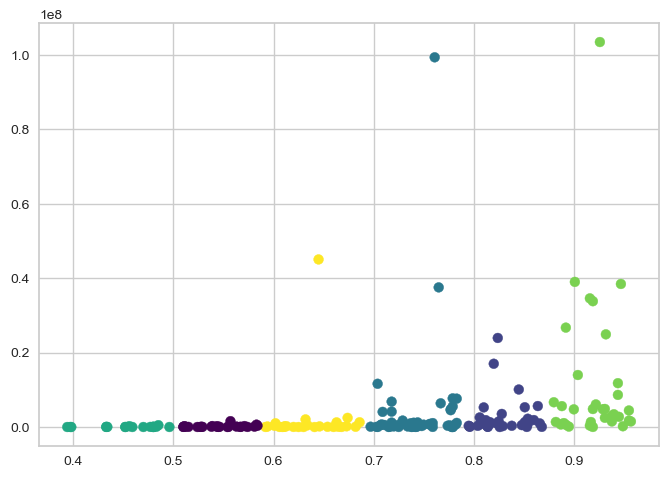

[[0.54526923]
 [0.82865714]
 [0.74384   ]
 [0.45327778]
 [0.92058824]
 [0.63603846]]


In [419]:
# Plot the clusters with colors representing different clusters
plt.scatter(last_row['human_development_index'].values.reshape(-1, 1), last_row['total_cases'].values.reshape(-1, 1), c=predictions, s=50, cmap='viridis')
plt.grid(True)
plt.show()

# Print cluster centers
print(kmeans.cluster_centers_)

In [420]:
print(kmeans.cluster_centers_)

[[0.54526923]
 [0.82865714]
 [0.74384   ]
 [0.45327778]
 [0.92058824]
 [0.63603846]]


In [421]:
# first column
x_min = X.min()
x_max = X.max()

# second column
y_min = y.min()
y_max = y.max()

In [422]:
#%pip install yellowbrick

In [423]:
# Import the SilhouetteVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [424]:
# Instantiate a visualizer with the number of clusters
k = 6
model = KMeans(n_clusters=k, n_init=10)
model.fit_predict(X)

c:\Users\Marcus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



array([1, 0, 2, 0, 1, 2, 0, 2, 3, 3, 2, 0, 0, 5, 0, 0, 3, 2, 1, 5, 2, 2,
       2, 2, 0, 0, 4, 4, 5, 1, 3, 5, 4, 4, 0, 2, 2, 1, 1, 0, 1, 0, 2, 3,
       3, 4, 3, 1, 2, 2, 2, 2, 5, 5, 4, 3, 5, 4, 2, 3, 3, 2, 4, 0, 3, 5,
       3, 2, 5, 4, 4, 5, 1, 5, 0, 3, 5, 2, 2, 5, 3, 3, 3, 2, 3, 2, 0, 5,
       5, 0, 2, 5, 0, 2, 1, 4, 2, 3, 3, 3, 1, 4, 0, 2, 4, 3, 2, 1, 0, 2,
       5, 2, 2, 0, 5, 4, 1, 5, 5, 3, 3, 5, 4, 1, 2, 3, 0, 1, 0, 2, 0, 1,
       2, 2, 2, 3, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 5, 0, 1, 0, 0, 4, 3, 0,
       3, 1, 2, 3, 4, 3, 2, 1, 2, 3, 3, 1, 5, 1, 2, 5, 1, 2, 0, 2, 0, 5,
       1, 2, 3, 3, 3, 0, 2, 5, 2, 2, 4, 1, 1])

In [425]:
from sklearn.metrics import silhouette_score

In [426]:
# Calculate the silhouette score
score = silhouette_score(X, model.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.575


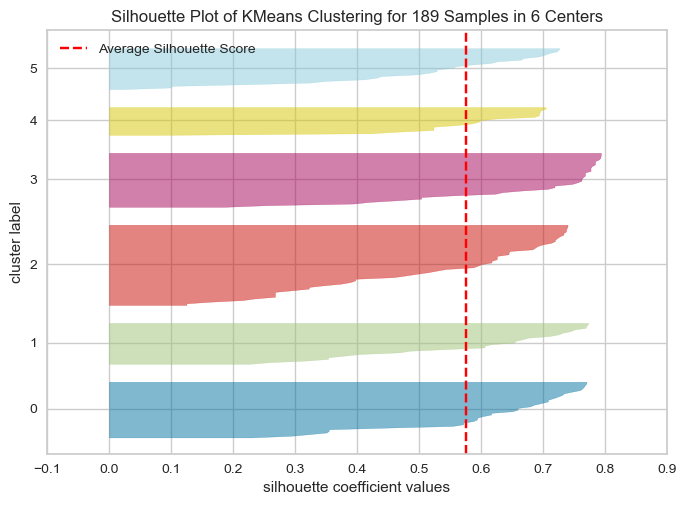

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 189 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [427]:
# Visualize the silhouette scores of all points
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()  

In [428]:
# Convert the dataset into array
array = last_row[['human_development_index', 'total_cases', 'cluster_label']].values

In [429]:
# X - features, all rows, all columns but the last one
# y - labels, all rows, the last column
X, y = array[:, :-1], array[:, -1]

In [430]:
# Separate input data into classes based on labels
class0 = np.array(X[y==0])
class1 = np.array(X[y==1])
class2 = np.array(X[y==2])
class3 = np.array(X[y==3])
class4 = np.array(X[y==4])
class5 = np.array(X[y==5])

In [431]:
# Split the dataset into into training and testing sets in proportion 8:2 
#   80% of it as training data
#   20% as a validation dataset
set_prop = 0.2

In [432]:
#  Initialize seed parameter for the random number generator used for the split
seed = 7

In [433]:
# Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [434]:
params = {'max_depth': 6}
classifier = DecisionTreeClassifier(**params)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [435]:
#Install the graphviz package
# %pip install graphviz
# %conda install python-graphviz

In [436]:
amount_class0 = len(class0)
amount_class1 = len(class1)
amount_class2 = len(class2)
amount_class3 = len(class3)
amount_class4 = len(class4)
amount_class5 = len(class5)

print(f"Amount of class 0: {amount_class0}")
print(f"Amount of class 1: {amount_class1}")
print(f"Amount of class 2: {amount_class2}")
print(f"Amount of class 3: {amount_class3}")
print(f"Amount of class 4: {amount_class4}")
print(f"Amount of class 5: {amount_class5}")

Amount of class 0: 26
Amount of class 1: 35
Amount of class 2: 50
Amount of class 3: 18
Amount of class 4: 34
Amount of class 5: 26


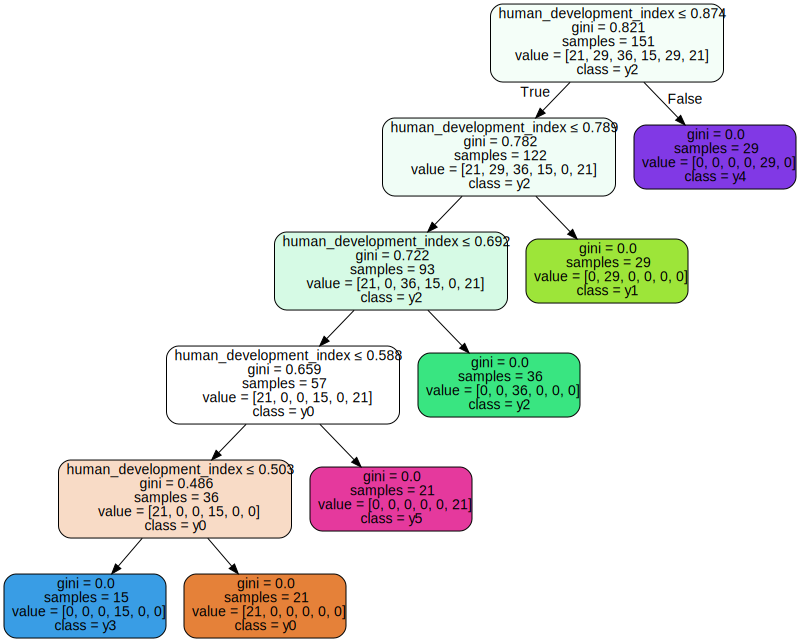

In [437]:
# draw tree from the trained data by graphviz package
import graphviz
gr_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=['human_development_index', 'total_cases'], class_names = True,        
                         filled=True, rounded=True, proportion = False, special_characters=True)  
dtree = graphviz.Source(gr_data) 
dtree 

In [438]:
# Predict the labels of the test data
y_testp = classifier.predict(X_test)
y_testp

array([2., 0., 4., 1., 1., 2., 0., 0., 2., 2., 2., 4., 0., 2., 2., 5., 3.,
       1., 3., 2., 0., 2., 2., 2., 2., 4., 2., 2., 5., 5., 4., 1., 4., 5.,
       1., 3., 5., 1.])

In [439]:
# Calculated the accuracy of the model comparing the observed data and predicted data
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  1.0


In [440]:
# Create confusion matrix
confusion_mat = confusion_matrix(y_test,y_testp)
confusion_mat

array([[ 5,  0,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  5,  0],
       [ 0,  0,  0,  0,  0,  5]], dtype=int64)

In [441]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,0.0,1.0,2.0,3.0,4.0,5.0
row_0,,,,,,
0.0,5,0,0,0,0,0
1.0,0,6,0,0,0,0
2.0,0,0,14,0,0,0
3.0,0,0,0,3,0,0
4.0,0,0,0,0,5,0
5.0,0,0,0,0,0,5


In [442]:
# Classifier performance on training dataset
class_names = ['Class0', 'Class1', 'Class2','Class3', 'Class4', 'Class5']
print(classification_report(y_train, classifier.predict(X_train), target_names=class_names))
plt.show()

              precision    recall  f1-score   support

      Class0       1.00      1.00      1.00        21
      Class1       1.00      1.00      1.00        29
      Class2       1.00      1.00      1.00        36
      Class3       1.00      1.00      1.00        15
      Class4       1.00      1.00      1.00        29
      Class5       1.00      1.00      1.00        21

    accuracy                           1.00       151
   macro avg       1.00      1.00      1.00       151
weighted avg       1.00      1.00      1.00       151



In [443]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [444]:
# test the model on the test set
model.score(X_test, y_test)

0.18421052631578946

#### Decision Tree model:

Accuracy: The Decision Tree model achieved an accuracy of 78.95%. This means that 78.95% of the predictions made by the model on the test dataset were correct. In other words, the model could correctly classify 78.95% of the cases it was presented with.

#### Naive Bayes model:

 Accuracy: The Naive Bayes model achieved an accuracy of 18.42%. This indicates that only 18.42% of the predictions made by the model were correct on the test dataset. Therefore, the model had a low performance level compared to the decision tree.

In [445]:
#Test til Vic

: 